In [18]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch


torch.manual_seed(13)

## Linear Regression in 1D

$\hat{y} = b + x \cdot w$, where $b,w \in \mathbb{R}$ - parameters

In [34]:
def forward(x):
    """Prediction
    x: tensor of 1d values
    """
    y = b + x * w
    return y


def mse(y_hat, y):
    """Computes Mean Squared Error
    y_hat: predictions
    y: ground truth
    """
    return torch.mean((y_hat - y) ** 2)


w = torch.tensor(2., requires_grad=True)
b = torch.tensor(-1., requires_grad=True)

x = torch.tensor([[2.0], [1.0]])
forward(x)

tensor([[3.],
        [1.]], grad_fn=<AddBackward0>)

In [11]:
from torch.nn import Linear


model = Linear(in_features=1, out_features=1)
[p for p in model.parameters()]

[Parameter containing:
 tensor([[0.8297]], requires_grad=True), Parameter containing:
 tensor([-0.0402], requires_grad=True)]

In [15]:
# equivalent to calling the forward method
model(x)

tensor([[1.6193],
        [0.7895]], grad_fn=<AddmmBackward>)

## Custom Modules

In [16]:
import torch.nn as nn


class LR(nn.Module):
    def __init__(self, in_size, out_size):
        super(LR, self).__init__()
        self.lr = Linear(in_size, out_size)
        
    def forward(self, x):
        out = self.lr(x)
        return out
    
    
lr = LR(1, 1)
lr(x)

tensor([[-0.3219],
        [-0.3915]], grad_fn=<AddmmBackward>)

In [17]:
lr.state_dict()

OrderedDict([('lr.weight', tensor([[0.0696]])),
             ('lr.bias', tensor([-0.4611]))])

## Training

Given training data $X = \{(x_1, y_1), \ldots, (x_N, y_N)\}$ we would like to find $\hat{y} = b + x \cdot w$ such that the following loss function is minimized wrt $b, w$:

$$l(X \mid w,b) = \frac{1}{N}\sum\limits_{i=1}^{N} (y_i - \hat{y}(x_i))^2 .$$

We can do this using Gradient Descent:

$$w^{(t)} := w^{(t-1)} - \eta \frac{\partial l(X \mid w)}{\partial w},$$
where $\eta$ - learning rate.

### Hard Way

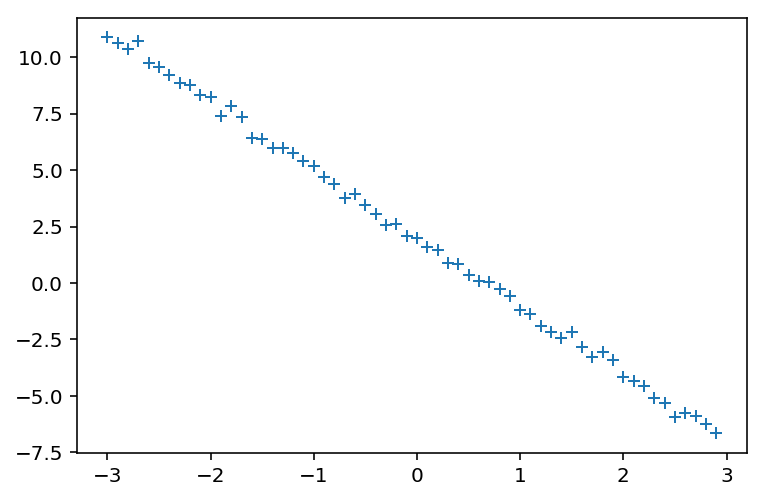

In [49]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Data(Dataset):
    def __init__(self, transform = None):
        self.X = torch.arange(-3.0, 3.0, 0.1)
        # underlying true function
        self.f = -3 * X + 2
        self.Y = f + 0.2 * torch.randn(X.size())
        self.transform = transform
     
    def __getitem__(self, index):
        sample = self.X[index], self.Y[index]
        if self.transform:
            sample = self.transform(sample)     
        return sample
    
    def __len__(self):
        return self.X.shape[0]


x, y = zip(*[(x, y) for x, y in Data()])
plt.plot(x, y, '+')
plt.show()

In [54]:
dataset = Data()
dataloader = DataLoader(dataset=dataset, batch_size=5)

w = torch.tensor(-10.0, requires_grad=True)
b = torch.tensor(-10.0, requires_grad=True)

eta = 0.1
losses = []
for epoch in range(7):
    total_loss = 0
    
    for x, y in dataloader:
        Y_hat = forward(x)
        loss = mse(Y_hat, y)
        total_loss += loss.item()

        loss.backward()

        w.data = w.data - eta * w.grad.data
        b.data = b.data - eta * b.grad.data

#         print(k, w.data, b.data, loss.data)

        w.grad.data.zero_()
        b.grad.data.zero_()
        
    losses.append(total_loss)

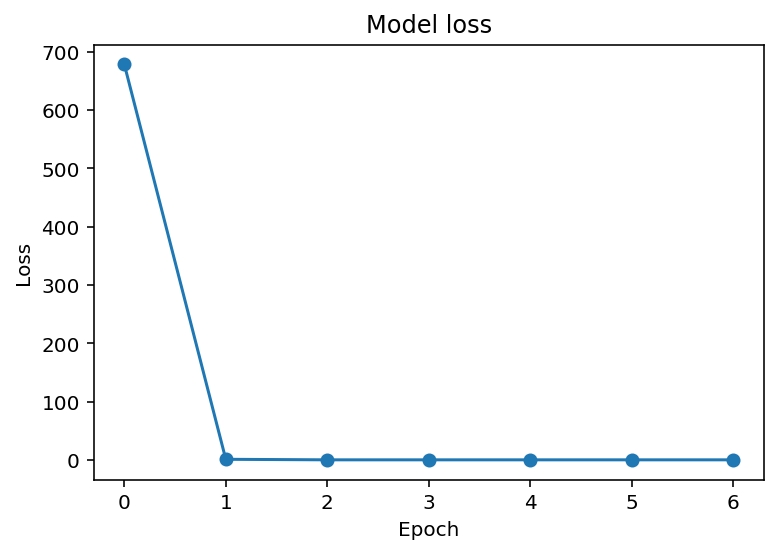

In [55]:
plt.plot(losses, marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Pytorch Way

In [65]:
from torch import nn, optim


dataset = Data()
dataloader = DataLoader(dataset=dataset, batch_size=1)

loss_f = nn.MSELoss()

lr = LR(1, 1)
optimizer = optim.SGD(lr.parameters(), lr=0.1)

losses = []
for epoch in range(7):
    total_loss = 0
    
    for x, y in dataloader:
        optimizer.zero_grad()
        
        loss = loss_f(lr(x), y)
        loss.backward()
        total_loss += loss.item()
        
        # updates parameters of the LR model
        optimizer.step()
        
    losses.append(total_loss)

In [66]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [112171395184, 112167143968]}]}

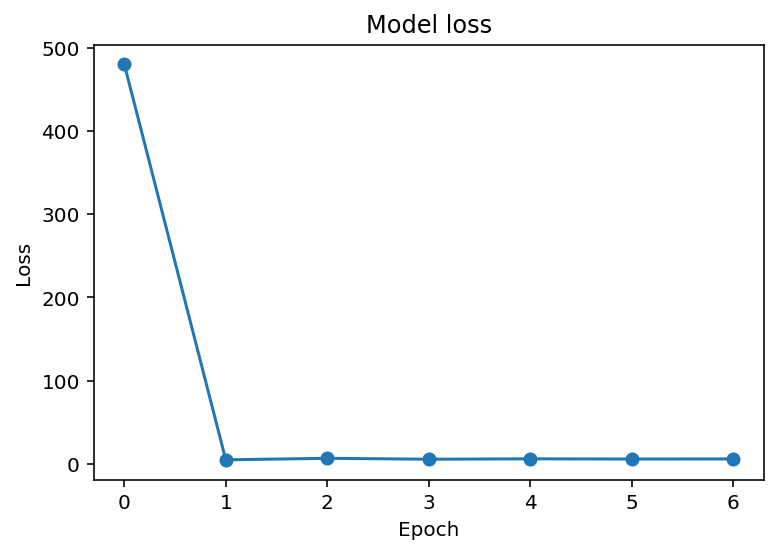

In [67]:
plt.plot(losses, marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()